# Heisenberg XXX model

$$ H_{\text{TFIM}} = \sum_{j=1}^{L}(X_jX_{j+1}+Y_jY_{j+1}+Z_jZ_{j+1}) $$

pip install qrisp 

https://www.qrisp.eu


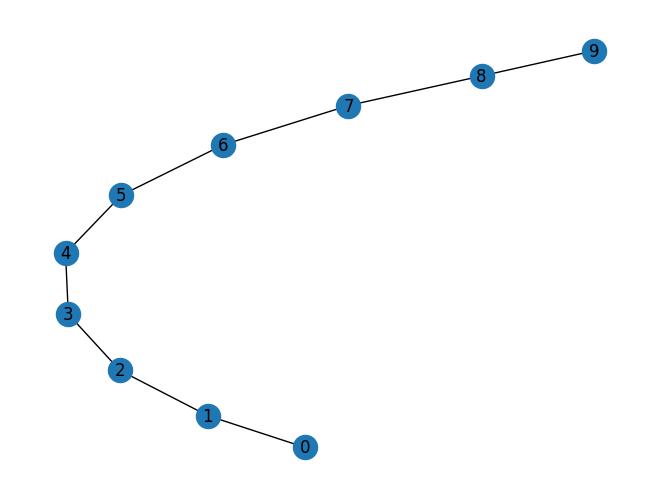

In [1]:
import networkx as nx

# Create a graph
L = 10
G = nx.Graph()
G.add_edges_from([(k,k+1) for k in range(L-1)]) 
nx.draw(G, with_labels=True)

## Define Heisenberg Hamiltonian

In [2]:
from qrisp.operators import X, Y, Z

def create_heisenberg_hamiltonian(G):
    H = sum(X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) for (i,j) in G.edges())
    return H

H = create_heisenberg_hamiltonian(G)
print(H)

X(0)*X(1) + X(1)*X(2) + X(2)*X(3) + X(3)*X(4) + X(4)*X(5) + X(5)*X(6) + X(6)*X(7) + X(7)*X(8) + X(8)*X(9) + Y(0)*Y(1) + Y(1)*Y(2) + Y(2)*Y(3) + Y(3)*Y(4) + Y(4)*Y(5) + Y(5)*Y(6) + Y(6)*Y(7) + Y(7)*Y(8) + Y(8)*Y(9) + Z(0)*Z(1) + Z(1)*Z(2) + Z(2)*Z(3) + Z(3)*Z(4) + Z(4)*Z(5) + Z(5)*Z(6) + Z(6)*Z(7) + Z(7)*Z(8) + Z(8)*Z(9)


## Calculate eigenvalues clasically

In [3]:
import scipy
matrix = H.to_sparse_matrix()
scipy.sparse.linalg.eigs(matrix)

(array([-17.03214083+3.44761314e-17j, -15.72269436-4.07694302e-17j,
        -14.10817429-5.87491153e-17j, -15.72269436+2.77555758e-17j,
        -15.72269436-2.41909433e-17j, -14.10817429+3.72678400e-17j]),
 array([[-1.24136280e-18-7.66297108e-21j,  1.82535827e-20-2.11829380e-18j,
         -4.62331678e-21+8.95228203e-19j,  1.66912420e-19-7.22575255e-18j,
          1.93441316e-17-8.02080358e-19j, -2.78569535e-17+2.19798259e-17j],
        [-3.22008041e-18-2.07974501e-18j, -1.16251347e-17+7.45754704e-18j,
         -1.34530146e-17-4.16582335e-18j, -8.81158034e-18+2.69793173e-18j,
         -1.64294434e-17-1.23278796e-17j,  4.21350600e-17+1.97567357e-17j],
        [-8.01181965e-19-2.46421592e-18j, -4.91491989e-18+2.75179613e-18j,
         -1.19505429e-17-1.56966910e-18j, -3.21058232e-18+5.35336824e-19j,
         -8.41670304e-18-6.60082958e-18j,  4.16216992e-17+9.10972395e-18j],
        ...,
        [ 3.44172279e-18-8.90676273e-19j, -6.67553107e-18+6.09278542e-18j,
          3.09826669e-18+2.9

## VQE warm start 

* 2 layers of problem specific Ansatz: https://arxiv.org/abs/2108.08086, https://qrisp.eu/reference/Algorithms/vqe/vqeProblems/heisenberg.html

In [4]:
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *

vqe = heisenberg_problem(G,1,0)
U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=1,max_iter=100)

qv = QuantumVariable(G.number_of_nodes())
U_0(qv)
E_0 = H.get_measurement(qv,precision=0.01)
print(E_0)


-16.325377406056276                                                                  


## QPE

Recall that $n+\lceil \log(2+\frac{1}{2\epsilon})\rceil$ precision qubits for QPE yield an estimate accurate to $n$ bits with probability $1-\epsilon$.

In [ ]:
from qrisp import QPE

qv = QuantumVariable(G.number_of_nodes())
U_0(qv)

# Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps 
# Note: 5 steps are insufficient to obtain the ground state energy within error 0.1 (10 steps are sufficent)
def exp_H(qv, t=1, iter=1):
    H.trotterization(forward_evolution=False,method='commuting')(qv, t, 5, iter)

qpe_res = QPE(qv,exp_H,precision=5,iter_spec=True)
qc = qpe_res.qs.compile()
tqc = qc.transpile(basis_gates=["cx","u"])
print(qc.count_ops())
print(tqc.count_ops())
print(tqc.num_qubits())
print(tqc.depth())

{'x': 10, 'h': 8090, 'p': 42, 'cx': 11211, 'rz': 8380, 'cz': 2790, 'QFT_dg': 1, 'gphase': 1}
{'u3': 16676, 'cx': 14027}
15
12593


In [6]:
results = qpe_res.get_measurement(precompiled_qc=qc)
sorted_results= dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

In [7]:
sorted_results

{0.34375: 0.5971719434388687,
 0.875: 0.11688233764675292,
 0.375: 0.09768195363907277,
 0.78125: 0.04937098741974839,
 0.3125: 0.03167063341266825,
 0.84375: 0.014410288205764113,
 0.125: 0.011290225804516088,
 0.8125: 0.010870217404348086,
 0.09375: 0.009010180203604072,
 0.40625: 0.008950179003580071,
 0.28125: 0.007420148402968059,
 0.625: 0.005590111802236045,
 0.90625: 0.005570111402228044,
 0.4375: 0.003530070601412028,
 0.75: 0.003290065801316026,
 0.6875: 0.003270065401308026,
 0.25: 0.002300046000920018,
 0.46875: 0.002130042600852017,
 0.9375: 0.001980039600792016,
 0.15625: 0.0019200384007680153,
 0.1875: 0.0019200384007680153,
 0.65625: 0.0017200344006880136,
 0.21875: 0.0015600312006240123,
 0.71875: 0.001540030800616012,
 0.0625: 0.001510030200604012,
 0.5: 0.0013100262005240103,
 0.53125: 0.0012800256005120103,
 0.96875: 0.0012000240004800093,
 0.03125: 0.0009600192003840077,
 0.0: 0.0009500190003800075,
 0.59375: 0.000890017800356007,
 0.5625: 0.0008500170003400067}

## Find ground state engergy

* Exact solution: -17.03214083
* QPE results are modulo $2\pi$: $-17.03214083 + 4\pi = -4.465770215640827$
* Subtract $4\pi$ from solution

In [8]:
import numpy as np

for phi,prob in list(sorted_results.items())[:5]:
    E_qpe = 2*np.pi*(phi-1) # Results are modulo 2*pi, therefore subtract 2*pi
    E_qpe -= 4*np.pi 
    print("Energy: " + str(E_qpe) + " Probability: " + str(prob))

Energy: -16.689710972195776 Probability: 0.5971719434388687
Energy: -13.351768777756622 Probability: 0.11688233764675292
Energy: -16.493361431346415 Probability: 0.09768195363907277
Energy: -13.940817400304708 Probability: 0.04937098741974839
Energy: -16.886060513045138 Probability: 0.03167063341266825
